# Releases

- Adicionando o extrator OpenFace na Análise

## Configuração

Env conda: 2way

# Análise Comparativa de Extratores de Features Faciais

Neste jupyter notebook, podemos realizar a leitura dos arquivos que contém as features extraídas da face (landmarks) e compará-los a nível de quantidade de frames com landmarks detectados entre o tipo do extrator vs variação de data augmentation.


Os augmentation foram realizados a partir do script 'FacialActionLibras/src/data/augmentation.py'

## Extratores: 

- Dlib
- Mediapipe
- OpenFace

## Augmentations:

- rot90
    - Parâmetros: k=1
- adjust_contrast
    - Parâmetros: contrast_factor=0.25
- adjust_hue
    - Parâmetros: delta=1.5
- stateless_random_brightness
    - Parâmetros: max_delta=0.95, seed=(0,0)
- adjust_jpeg_quality
    - Parâmetros: jpeg_quality==10
- adjust_brightness
    - Parâmetros: delta=0.5
- rgb_to_grayscale

## Referência:
https://www.tensorflow.org/api_docs/python/tf/image/


In [1]:
!pip install mediapy

In [2]:
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
import cv2
import utils as u


## Load Data

In [3]:
def get_name_video(string):
    new_name = string.split('/')[-1]
    return new_name

def get_files(path, extrator, aug, extension):
    """
    Descrição: Recebe um path e lista todos os arquivos e seta o extrator + tipo de augmentation
    Retorna um dataframe com todos os files concatenados de um determinado path
    """
    all_filenames = []
    df = pd.DataFrame()
    df_interno = pd.DataFrame()

    if(aug == 'original'):
        all_filenames = [i for i in glob.glob(path+'*.{}'.format(extension))]
    else:
        all_filenames = [i for i in glob.glob(path+aug+'/'+'*.{}'.format(extension))]
        
    if(len(all_filenames) > 0):
        
        for f in all_filenames:    
            df_interno = pd.read_csv(f, sep=";", index_col=None)
            if(' video_name' in df_interno.columns):
                df_interno.rename(columns={' video_name':'video_name'}, inplace=True)

            df = pd.concat([df, df_interno], axis=0)

        #df = pd.concat([pd.read_csv(f, sep=";", index_col=None) for f in all_filenames ])
        df['extractor'] = extrator
        df['aug'] = aug
        #print(df['video_name'])

        df['video_name'] = df.apply(lambda row : get_name_video(row['video_name']), axis = 1)
        df['video_name'] = df['video_name'].str.split('.', expand=True)[0]
        df['class'] = df['video_name'].str.split('_', expand=True)[1]
        
        
        
        return df[['frame', 'video_name', 'keys', 'extractor', 'aug', 'class']]
        
    



def join_files(paths, aug, extension='csv'):
    
    """
    Descrição: Recebe um dict dos paths de cada base submetida por cada extrator
    Retorna o dataframe combinado
    """
    
    df_combined = pd.DataFrame()
    
    if(aug=='original'):

        for key, value in paths.items():
            print(key, value)
            df = get_files(value, key, aug, extension)
            df_combined = pd.concat([df_combined, df], axis=0)
    
    elif(aug=='aug'):
        
        for key, value in paths.items():
            print(key, value)
            for aug in os.listdir(paths[key]):
                print(aug)
                df = get_files(value, key, aug, extension='csv')
                df_combined = pd.concat([df_combined, df], axis=0)
        
        
    return df_combined


In [4]:
#Original
inputs_orig = {
    'dlib': '../../data/processed/dlib/UCF-101-Analysis/',
    'mediapipe': '../../data/processed/mediapipe/UCF-101-Analysis/',
    'openface': '../../data/processed/openface/UCF-101-Analysis/'
}

df_combined_orig = join_files(inputs_orig, aug='original', extension='csv')
df_combined_orig.shape

dlib ../../data/processed/dlib/UCF-101-Analysis/
mediapipe ../../data/processed/mediapipe/UCF-101-Analysis/
openface ../../data/processed/openface/UCF-101-Analysis/


(403452, 6)

In [5]:
df_combined_orig

frame                video_name  \
0        1   v_BrushingTeeth_g21_c04   
1        2   v_BrushingTeeth_g21_c04   
2        3   v_BrushingTeeth_g21_c04   
3        4   v_BrushingTeeth_g21_c04   
4        5   v_BrushingTeeth_g21_c04   
..     ...                       ...   
176    177  v_ApplyEyeMakeup_g20_c06   
177    178  v_ApplyEyeMakeup_g20_c06   
178    179  v_ApplyEyeMakeup_g20_c06   
179    180  v_ApplyEyeMakeup_g20_c06   
180    181  v_ApplyEyeMakeup_g20_c06   

                                                  keys extractor       aug  \
0    [[70, 27], [68, 48], [69, 70], [75, 92], [83, ...      dlib  original   
1    [[82, 31], [80, 49], [80, 69], [84, 87], [88, ...      dlib  original   
2    [[77, 28], [75, 47], [76, 68], [80, 88], [86, ...      dlib  original   
3    [[79, 30], [77, 48], [77, 68], [81, 88], [86, ...      dlib  original   
4    [[77, 28], [75, 45], [75, 65], [79, 85], [83, ...      dlib  original   
..                                                 ...       ...       ...   
176  [[83.8, 94.2],[84.0, 111.6],[86.0, 128.8],[89....  openface  original   
177  [[83.9, 95.6],[84.4, 113.2],[86.6, 130.7],[90....  openface  original   
178  [[84.4, 91.9],[84.3, 109.3],[86.1, 126.8],[89....  openface  original   
179  [[84.7, 89.3],[84.3, 106.7],[85.7, 124.4],[88....  openface  original   
180  [[85.5, 88.7],[84.8, 105.9],[86.0, 123.4],[88....  openface  original   

              class  
0     BrushingTeeth  
1     BrushingTeeth  
2     BrushingTeeth  
3     BrushingTeeth  
4     BrushingTeeth  
..              ...  
176  ApplyEyeMakeup  
177  ApplyEyeMakeup  
178  ApplyEyeMakeup  
179  ApplyEyeMakeup  
180  ApplyEyeMakeup  

[403452 rows x 6 columns]

In [6]:
#Augmentation
inputs_aug = {
    'dlib': '../../data/processed/dlib/UCF-101-Analysis-augmentation/',
    'mediapipe': '../../data/processed/mediapipe/UCF-101-Analysis-augmentation/',
    'openface': '../../data/processed/openface/UCF-101-Analysis-augmentation/'
}

df_combined_aug = join_files(inputs_aug, aug='aug', extension='csv')
df_combined_aug.shape
        

dlib ../../data/processed/dlib/UCF-101-Analysis-augmentation/
rot90
adjust_contrast
adjust_hue
stateless_random_brightness
adjust_jpeg_quality
adjust_brightness
rgb_to_grayscale
mediapipe ../../data/processed/mediapipe/UCF-101-Analysis-augmentation/
rot90
adjust_contrast
adjust_hue
stateless_random_brightness
adjust_jpeg_quality
adjust_brightness
rgb_to_grayscale
openface ../../data/processed/openface/UCF-101-Analysis-augmentation/
rot90
adjust_contrast
log
adjust_hue
stateless_random_brightness
adjust_jpeg_quality
adjust_brightness
rgb_to_grayscale


(2824164, 6)

In [7]:
df_combined_aug

frame                video_name  \
0        1   v_BrushingTeeth_g21_c04   
1        2   v_BrushingTeeth_g21_c04   
2        3   v_BrushingTeeth_g21_c04   
3        4   v_BrushingTeeth_g21_c04   
4        5   v_BrushingTeeth_g21_c04   
..     ...                       ...   
176    177  v_ApplyEyeMakeup_g20_c06   
177    178  v_ApplyEyeMakeup_g20_c06   
178    179  v_ApplyEyeMakeup_g20_c06   
179    180  v_ApplyEyeMakeup_g20_c06   
180    181  v_ApplyEyeMakeup_g20_c06   

                                                  keys extractor  \
0                                                  NaN      dlib   
1                                                  NaN      dlib   
2                                                  NaN      dlib   
3                                                  NaN      dlib   
4                                                  NaN      dlib   
..                                                 ...       ...   
176  [[83.8, 92.9],[83.8, 110.0],[85.5, 127.1],[88....  openface   
177  [[83.8, 94.8],[84.1, 112.2],[86.2, 129.6],[89....  openface   
178  [[84.4, 91.4],[84.2, 108.8],[85.9, 126.2],[88....  openface   
179  [[84.7, 89.1],[84.2, 106.6],[85.7, 124.2],[88....  openface   
180  [[85.5, 88.7],[84.9, 106.1],[86.2, 123.6],[88....  openface   

                  aug           class  
0               rot90   BrushingTeeth  
1               rot90   BrushingTeeth  
2               rot90   BrushingTeeth  
3               rot90   BrushingTeeth  
4               rot90   BrushingTeeth  
..                ...             ...  
176  rgb_to_grayscale  ApplyEyeMakeup  
177  rgb_to_grayscale  ApplyEyeMakeup  
178  rgb_to_grayscale  ApplyEyeMakeup  
179  rgb_to_grayscale  ApplyEyeMakeup  
180  rgb_to_grayscale  ApplyEyeMakeup  

[2824164 rows x 6 columns]

In [8]:
#Concat Augmentation and Original
        
df_combined = pd.concat([df_combined_orig, df_combined_aug], axis=0)
df_combined['na'] = np.where(df_combined['keys'].isna(), 1, 0)
df_combined.head(2)

frame               video_name  \
0      1  v_BrushingTeeth_g21_c04   
1      2  v_BrushingTeeth_g21_c04   

                                                keys extractor       aug  \
0  [[70, 27], [68, 48], [69, 70], [75, 92], [83, ...      dlib  original   
1  [[82, 31], [80, 49], [80, 69], [84, 87], [88, ...      dlib  original   

           class  na  
0  BrushingTeeth   0  
1  BrushingTeeth   0

In [9]:
df_combined['class'].unique()

array(['BrushingTeeth', 'ApplyEyeMakeup', 'ShavingBeard', 'PlayingFlute'],
      dtype=object)

In [10]:
print('Quantidade de Frames [Dlib]: '+str(df_combined.loc[df_combined.extractor == 'dlib'].shape))
print('Quantidade de Frames [Mediapipe]: '+str(df_combined.loc[df_combined.extractor == 'mediapipe'].shape))
print('Quantidade de Frames [OpenFace]: '+str(df_combined.loc[df_combined.extractor == 'openface'].shape))

Quantidade de Frames [Dlib]: (1075872, 7)
Quantidade de Frames [Mediapipe]: (1075872, 7)
Quantidade de Frames [OpenFace]: (1075872, 7)


# Por Augmentation

In [11]:
df_combined.groupby(['extractor', 'aug']).size().reset_index(name='counts')

extractor                          aug  counts
0        dlib            adjust_brightness  134484
1        dlib              adjust_contrast  134484
2        dlib                   adjust_hue  134484
3        dlib          adjust_jpeg_quality  134484
4        dlib                     original  134484
5        dlib             rgb_to_grayscale  134484
6        dlib                        rot90  134484
7        dlib  stateless_random_brightness  134484
8   mediapipe            adjust_brightness  134484
9   mediapipe              adjust_contrast  134484
10  mediapipe                   adjust_hue  134484
11  mediapipe          adjust_jpeg_quality  134484
12  mediapipe                     original  134484
13  mediapipe             rgb_to_grayscale  134484
14  mediapipe                        rot90  134484
15  mediapipe  stateless_random_brightness  134484
16   openface            adjust_brightness  134484
17   openface              adjust_contrast  134484
18   openface                   adjust_hue  134484
19   openface          adjust_jpeg_quality  134484
20   openface                     original  134484
21   openface             rgb_to_grayscale  134484
22   openface                        rot90  134484
23   openface  stateless_random_brightness  134484

In [12]:
label_mediapipe = 'mediapipe'
label_dlib = 'dlib'
label_openface = 'openface'

print("----- Description -----")
mdnna = (len(df_combined.loc[(df_combined.extractor == label_mediapipe) & (df_combined['keys'].notna())])/len(df_combined))
mdna = (len(df_combined.loc[(df_combined.extractor == label_mediapipe) & (df_combined['keys'].isna())])/len(df_combined))
dbnna = (len(df_combined.loc[(df_combined.extractor == label_dlib) & (df_combined['keys'].notna())])/len(df_combined))
dbna = (len(df_combined.loc[(df_combined.extractor == label_dlib) & (df_combined['keys'].isna())])/len(df_combined))
ofnna = (len(df_combined.loc[(df_combined.extractor == label_openface) & (df_combined['keys'].notna())])/len(df_combined))
ofna = (len(df_combined.loc[(df_combined.extractor == label_openface) & (df_combined['keys'].isna())])/len(df_combined))


print("Porcentagem frames com landmarks detectados Mediapipe: {:.2f}%".format(mdnna))
print("Porcentagem frames com landmarks NÃO detectados Mediapipe: {:.2f}%".format(mdna))
print("Porcentagem frames com landmarks detectados Dlib: {:.2f}%".format(dbnna))
print("Porcentagem frames com landmarks NÃO detectados Dlib: {:.2f}%".format(dbna))
print("Porcentagem frames com landmarks detectados Dlib: {:.2f}%".format(ofnna))
print("Porcentagem frames com landmarks NÃO detectados Dlib: {:.2f}%".format(ofna))
    

----- Description -----
Porcentagem frames com landmarks detectados Mediapipe: 0.20%
Porcentagem frames com landmarks NÃO detectados Mediapipe: 0.13%
Porcentagem frames com landmarks detectados Dlib: 0.08%
Porcentagem frames com landmarks NÃO detectados Dlib: 0.25%
Porcentagem frames com landmarks detectados Dlib: 0.15%
Porcentagem frames com landmarks NÃO detectados Dlib: 0.18%


In [13]:
df_combined.groupby(['aug', 'na', 'extractor']).count().reset_index()[['aug', 'na','extractor', 'frame']]

aug  na  extractor   frame
0             adjust_brightness   0       dlib   40661
1             adjust_brightness   0  mediapipe   87629
2             adjust_brightness   0   openface   66011
3             adjust_brightness   1       dlib   93823
4             adjust_brightness   1  mediapipe   46855
5             adjust_brightness   1   openface   68473
6               adjust_contrast   0       dlib   35081
7               adjust_contrast   0  mediapipe   75504
8               adjust_contrast   0   openface   57887
9               adjust_contrast   1       dlib   99403
10              adjust_contrast   1  mediapipe   58980
11              adjust_contrast   1   openface   76597
12                   adjust_hue   0       dlib   45454
13                   adjust_hue   0  mediapipe   38457
14                   adjust_hue   0   openface   51904
15                   adjust_hue   1       dlib   89030
16                   adjust_hue   1  mediapipe   96027
17                   adjust_hue   1   openface   82580
18          adjust_jpeg_quality   0       dlib   31892
19          adjust_jpeg_quality   0  mediapipe   84919
20          adjust_jpeg_quality   0   openface   86607
21          adjust_jpeg_quality   1       dlib  102592
22          adjust_jpeg_quality   1  mediapipe   49565
23          adjust_jpeg_quality   1   openface   47877
24                     original   0       dlib   45776
25                     original   0  mediapipe  110407
26                     original   0   openface   91647
27                     original   1       dlib   88708
28                     original   1  mediapipe   24077
29                     original   1   openface   42837
30             rgb_to_grayscale   0       dlib   42841
31             rgb_to_grayscale   0  mediapipe   99262
32             rgb_to_grayscale   0   openface   83125
33             rgb_to_grayscale   1       dlib   91643
34             rgb_to_grayscale   1  mediapipe   35222
35             rgb_to_grayscale   1   openface   51359
36                        rot90   0       dlib     131
37                        rot90   0  mediapipe   88603
38                        rot90   0   openface   13754
39                        rot90   1       dlib  134353
40                        rot90   1  mediapipe   45881
41                        rot90   1   openface  120730
42  stateless_random_brightness   0       dlib   18962
43  stateless_random_brightness   0  mediapipe   61389
44  stateless_random_brightness   0   openface   46993
45  stateless_random_brightness   1       dlib  115522
46  stateless_random_brightness   1  mediapipe   73095
47  stateless_random_brightness   1   openface   87491

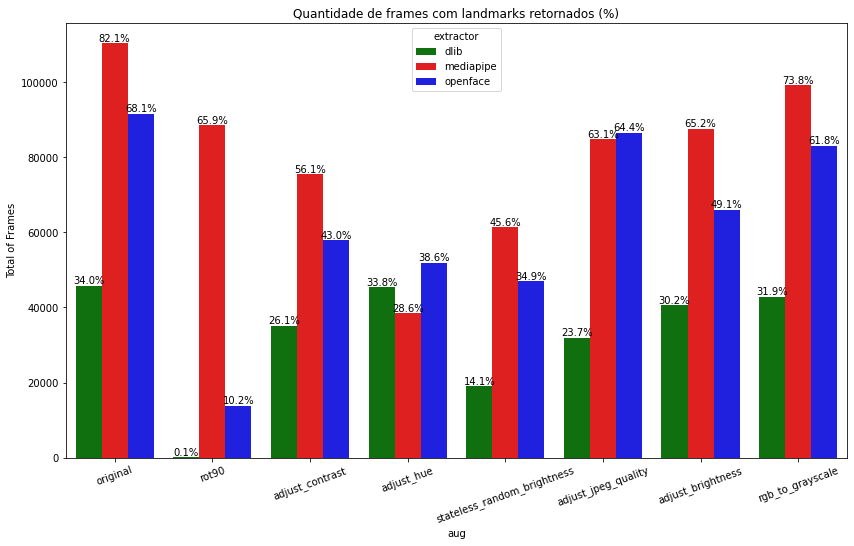

In [74]:
def plt_bar_extract_na(df_combined, na):
    fig = plt.figure(figsize=(14,8))
    count = 1
    colors = ['green', "red", 'blue']

    df = df_combined.loc[(df_combined['na'] == na)].reset_index()
    ax = sns.countplot(x="aug", hue="extractor", data=df, palette=colors)
    ax.set(ylabel='Total of Frames', title='Quantidade de frames com landmarks retornados (%)')
    idx_extractor=0
    for c in ax.containers:
        qt_extractores = len(df_combined.extractor.unique())
        qt_aug = len(df_combined.aug.unique())
        
        #labels = [f'{w/len(df.index)*len(df.aug.unique())*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        labels = [f'{w/((len(df_combined)/qt_extractores)/qt_aug)*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
        idx_extractor=idx_extractor+1
        
    plt.xticks(rotation=20)
    
    
plt_bar_extract_na(df_combined,  0)

In [15]:
def plt_bar_extract(df_combined, extractor):
    fig = plt.figure(figsize=(14,8))
    count = 1
    colors = ['green',"red", 'blue']

    df = df_combined.loc[(df_combined['extractor'] == extractor)]
    ax = sns.countplot(x="aug", hue="na", data=df, palette=colors)
    ax.set(ylabel='Total of Frames', title=extractor)
    for c in ax.containers:
        labels = [f'{w/len(df.index)*len(df.aug.unique())*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    plt.xticks(rotation=20)



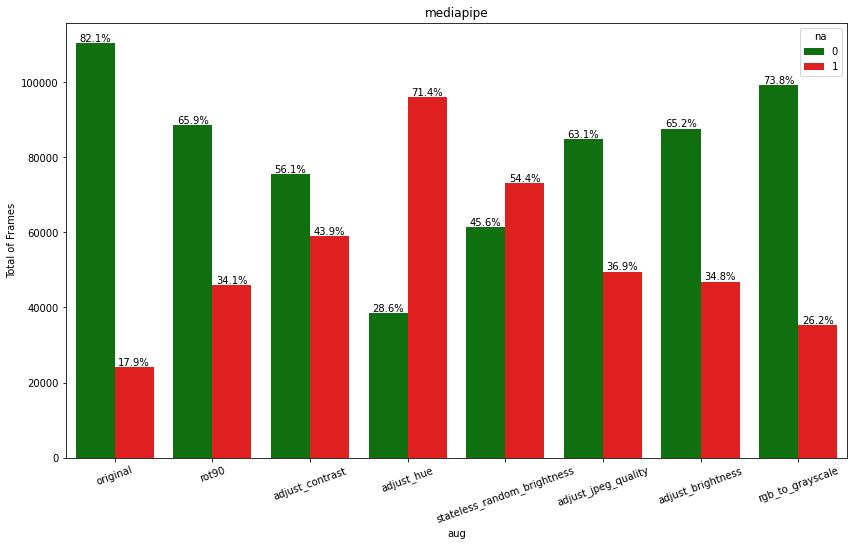

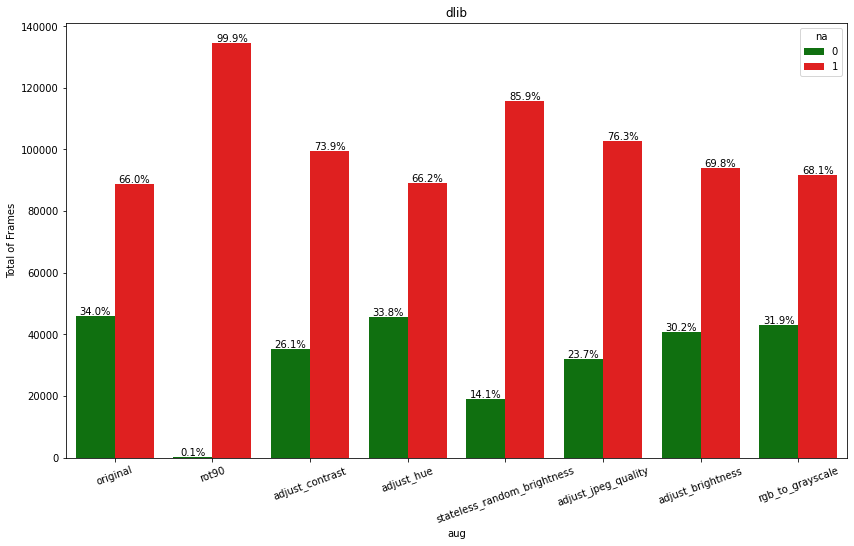

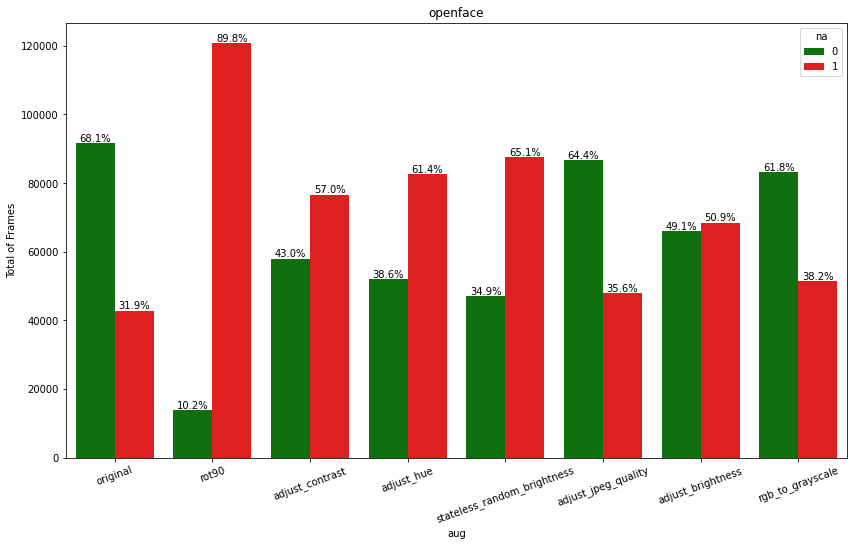

In [16]:
plt_bar_extract(df_combined,  'mediapipe')
plt_bar_extract(df_combined,  'dlib')
plt_bar_extract(df_combined,  'openface')

In [17]:
dados = df_combined.groupby(['extractor', 'aug', 'na']).size().reset_index(name='counts')


In [75]:
dados.loc[dados.na == 1]

extractor                          aug  na  counts
1        dlib            adjust_brightness   1   93823
3        dlib              adjust_contrast   1   99403
5        dlib                   adjust_hue   1   89030
7        dlib          adjust_jpeg_quality   1  102592
9        dlib                     original   1   88708
11       dlib             rgb_to_grayscale   1   91643
13       dlib                        rot90   1  134353
15       dlib  stateless_random_brightness   1  115522
17  mediapipe            adjust_brightness   1   46855
19  mediapipe              adjust_contrast   1   58980
21  mediapipe                   adjust_hue   1   96027
23  mediapipe          adjust_jpeg_quality   1   49565
25  mediapipe                     original   1   24077
27  mediapipe             rgb_to_grayscale   1   35222
29  mediapipe                        rot90   1   45881
31  mediapipe  stateless_random_brightness   1   73095
33   openface            adjust_brightness   1   68473
35   openface              adjust_contrast   1   76597
37   openface                   adjust_hue   1   82580
39   openface          adjust_jpeg_quality   1   47877
41   openface                     original   1   42837
43   openface             rgb_to_grayscale   1   51359
45   openface                        rot90   1  120730
47   openface  stateless_random_brightness   1   87491

In [19]:
df_combined

frame                video_name  \
0        1   v_BrushingTeeth_g21_c04   
1        2   v_BrushingTeeth_g21_c04   
2        3   v_BrushingTeeth_g21_c04   
3        4   v_BrushingTeeth_g21_c04   
4        5   v_BrushingTeeth_g21_c04   
..     ...                       ...   
176    177  v_ApplyEyeMakeup_g20_c06   
177    178  v_ApplyEyeMakeup_g20_c06   
178    179  v_ApplyEyeMakeup_g20_c06   
179    180  v_ApplyEyeMakeup_g20_c06   
180    181  v_ApplyEyeMakeup_g20_c06   

                                                  keys extractor  \
0    [[70, 27], [68, 48], [69, 70], [75, 92], [83, ...      dlib   
1    [[82, 31], [80, 49], [80, 69], [84, 87], [88, ...      dlib   
2    [[77, 28], [75, 47], [76, 68], [80, 88], [86, ...      dlib   
3    [[79, 30], [77, 48], [77, 68], [81, 88], [86, ...      dlib   
4    [[77, 28], [75, 45], [75, 65], [79, 85], [83, ...      dlib   
..                                                 ...       ...   
176  [[83.8, 92.9],[83.8, 110.0],[85.5, 127.1],[88....  openface   
177  [[83.8, 94.8],[84.1, 112.2],[86.2, 129.6],[89....  openface   
178  [[84.4, 91.4],[84.2, 108.8],[85.9, 126.2],[88....  openface   
179  [[84.7, 89.1],[84.2, 106.6],[85.7, 124.2],[88....  openface   
180  [[85.5, 88.7],[84.9, 106.1],[86.2, 123.6],[88....  openface   

                  aug           class  na  
0            original   BrushingTeeth   0  
1            original   BrushingTeeth   0  
2            original   BrushingTeeth   0  
3            original   BrushingTeeth   0  
4            original   BrushingTeeth   0  
..                ...             ...  ..  
176  rgb_to_grayscale  ApplyEyeMakeup   0  
177  rgb_to_grayscale  ApplyEyeMakeup   0  
178  rgb_to_grayscale  ApplyEyeMakeup   0  
179  rgb_to_grayscale  ApplyEyeMakeup   0  
180  rgb_to_grayscale  ApplyEyeMakeup   0  

[3227616 rows x 7 columns]

# Diferença do Augmentation para a base Original

In [20]:
def diff_calcule(df_combined):
    
    df_diff_ofc = pd.DataFrame()
    
    for i in df_combined['extractor'].unique():
        df = df_combined.loc[(df_combined['extractor'] == i)]
        df_diff = pd.crosstab(df['aug'],df['na']).apply(lambda r: r/r.sum(), axis=1).reset_index()

        ## Diferença de porcentagem
        ref_origin =  df_diff.loc[df_diff.aug == 'original'].reset_index().at[0,0] #index, col
        print(ref_origin)

        df_diff['diff_original'] = df_diff[0] - ref_origin
        df_diff['extractor'] = i
        df_diff.rename(columns={0:'notna'}, inplace=True)
        del df_diff[1]
        
        df_diff_ofc = pd.concat([df_diff_ofc, df_diff], axis=0)
    
    return df_diff_ofc

In [21]:
df_diff = diff_calcule(df_combined)
df_diff

0.3403824990333423
0.8209675500431278
0.6814714018024449


na                          aug     notna  diff_original  extractor
0             adjust_brightness  0.302348      -0.038034       dlib
1               adjust_contrast  0.260856      -0.079526       dlib
2                    adjust_hue  0.337988      -0.002394       dlib
3           adjust_jpeg_quality  0.237143      -0.103239       dlib
4                      original  0.340382       0.000000       dlib
5              rgb_to_grayscale  0.318558      -0.021824       dlib
6                         rot90  0.000974      -0.339408       dlib
7   stateless_random_brightness  0.140998      -0.199384       dlib
0             adjust_brightness  0.651594      -0.169373  mediapipe
1               adjust_contrast  0.561435      -0.259533  mediapipe
2                    adjust_hue  0.285960      -0.535008  mediapipe
3           adjust_jpeg_quality  0.631443      -0.189524  mediapipe
4                      original  0.820968       0.000000  mediapipe
5              rgb_to_grayscale  0.738095      -0.082872  mediapipe
6                         rot90  0.658837      -0.162131  mediapipe
7   stateless_random_brightness  0.456478      -0.364489  mediapipe
0             adjust_brightness  0.490846      -0.190625   openface
1               adjust_contrast  0.430438      -0.251034   openface
2                    adjust_hue  0.385949      -0.295522   openface
3           adjust_jpeg_quality  0.643995      -0.037477   openface
4                      original  0.681471       0.000000   openface
5              rgb_to_grayscale  0.618103      -0.063368   openface
6                         rot90  0.102272      -0.579199   openface
7   stateless_random_brightness  0.349432      -0.332039   openface

In [22]:
df_diff.reset_index().copy()

na  index                          aug     notna  diff_original  extractor
0       0            adjust_brightness  0.302348      -0.038034       dlib
1       1              adjust_contrast  0.260856      -0.079526       dlib
2       2                   adjust_hue  0.337988      -0.002394       dlib
3       3          adjust_jpeg_quality  0.237143      -0.103239       dlib
4       4                     original  0.340382       0.000000       dlib
5       5             rgb_to_grayscale  0.318558      -0.021824       dlib
6       6                        rot90  0.000974      -0.339408       dlib
7       7  stateless_random_brightness  0.140998      -0.199384       dlib
8       0            adjust_brightness  0.651594      -0.169373  mediapipe
9       1              adjust_contrast  0.561435      -0.259533  mediapipe
10      2                   adjust_hue  0.285960      -0.535008  mediapipe
11      3          adjust_jpeg_quality  0.631443      -0.189524  mediapipe
12      4                     original  0.820968       0.000000  mediapipe
13      5             rgb_to_grayscale  0.738095      -0.082872  mediapipe
14      6                        rot90  0.658837      -0.162131  mediapipe
15      7  stateless_random_brightness  0.456478      -0.364489  mediapipe
16      0            adjust_brightness  0.490846      -0.190625   openface
17      1              adjust_contrast  0.430438      -0.251034   openface
18      2                   adjust_hue  0.385949      -0.295522   openface
19      3          adjust_jpeg_quality  0.643995      -0.037477   openface
20      4                     original  0.681471       0.000000   openface
21      5             rgb_to_grayscale  0.618103      -0.063368   openface
22      6                        rot90  0.102272      -0.579199   openface
23      7  stateless_random_brightness  0.349432      -0.332039   openface

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'adjust_brightness'),
  Text(1, 0, 'adjust_contrast'),
  Text(2, 0, 'adjust_hue'),
  Text(3, 0, 'adjust_jpeg_quality'),
  Text(4, 0, 'original'),
  Text(5, 0, 'rgb_to_grayscale'),
  Text(6, 0, 'rot90'),
  Text(7, 0, 'stateless_random_brightness')])

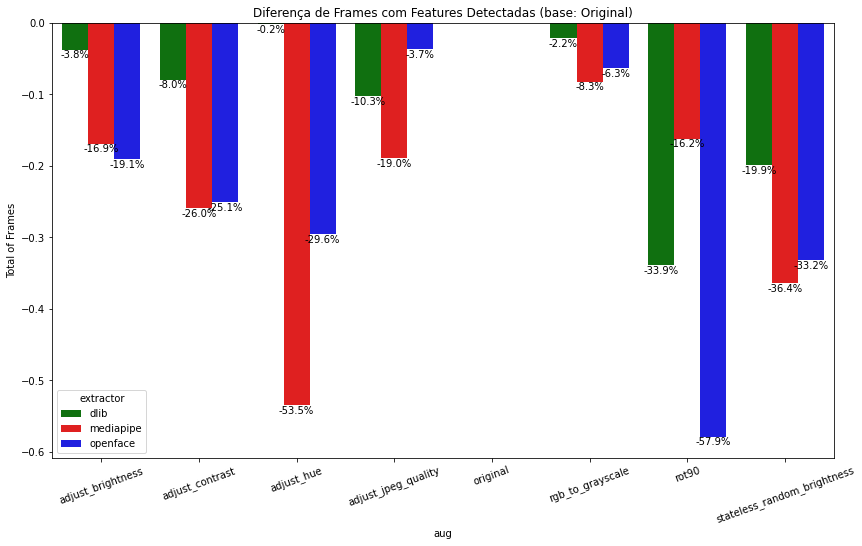

In [91]:
fig = plt.figure(figsize=(14,8))
count = 1
colors = ['green', "red", 'blue']
ax = sns.barplot(x="aug", y="diff_original", hue="extractor", data=df_diff, palette=colors)
ax.set(ylabel='Total of Frames', title='Diferença de Frames com Features Detectadas (base: Original)')

for c in ax.containers:
    labels = [f'{w*100:0.1f}%' if (w := v.get_height()) < 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
    
plt.xticks(rotation=20)



## Análise dos Gráficos

Ao considerar a diferença de quantidade de frames com landmarks detectados entre a base original e as variações de data augmentation, é possível perceber que o extrator Mediapipe é mais sensível ao ajuste de hue (matiz/tonalidade), redução de brilho e ajuste de contraste. 

Já o Dlib é muito sensível quando os dados estão rotacionados a 90° e podemos considerar que, ao observar os dados analisados, o Dlib é pouco sensível a dados com ajuste de hue (matiz/tonalidade) e escala de cinza.



In [24]:
def get_total_frames_unit(video, ext, aug, total_frames):
    return total_frames.loc[(total_frames.video_name == video) & 
                            (total_frames.extractor == ext) & 
                            (total_frames.aug == aug)].reset_index().at[0,'total_frames'] #index, col

In [25]:
df_combined

frame                video_name  \
0        1   v_BrushingTeeth_g21_c04   
1        2   v_BrushingTeeth_g21_c04   
2        3   v_BrushingTeeth_g21_c04   
3        4   v_BrushingTeeth_g21_c04   
4        5   v_BrushingTeeth_g21_c04   
..     ...                       ...   
176    177  v_ApplyEyeMakeup_g20_c06   
177    178  v_ApplyEyeMakeup_g20_c06   
178    179  v_ApplyEyeMakeup_g20_c06   
179    180  v_ApplyEyeMakeup_g20_c06   
180    181  v_ApplyEyeMakeup_g20_c06   

                                                  keys extractor  \
0    [[70, 27], [68, 48], [69, 70], [75, 92], [83, ...      dlib   
1    [[82, 31], [80, 49], [80, 69], [84, 87], [88, ...      dlib   
2    [[77, 28], [75, 47], [76, 68], [80, 88], [86, ...      dlib   
3    [[79, 30], [77, 48], [77, 68], [81, 88], [86, ...      dlib   
4    [[77, 28], [75, 45], [75, 65], [79, 85], [83, ...      dlib   
..                                                 ...       ...   
176  [[83.8, 92.9],[83.8, 110.0],[85.5, 127.1],[88....  openface   
177  [[83.8, 94.8],[84.1, 112.2],[86.2, 129.6],[89....  openface   
178  [[84.4, 91.4],[84.2, 108.8],[85.9, 126.2],[88....  openface   
179  [[84.7, 89.1],[84.2, 106.6],[85.7, 124.2],[88....  openface   
180  [[85.5, 88.7],[84.9, 106.1],[86.2, 123.6],[88....  openface   

                  aug           class  na  
0            original   BrushingTeeth   0  
1            original   BrushingTeeth   0  
2            original   BrushingTeeth   0  
3            original   BrushingTeeth   0  
4            original   BrushingTeeth   0  
..                ...             ...  ..  
176  rgb_to_grayscale  ApplyEyeMakeup   0  
177  rgb_to_grayscale  ApplyEyeMakeup   0  
178  rgb_to_grayscale  ApplyEyeMakeup   0  
179  rgb_to_grayscale  ApplyEyeMakeup   0  
180  rgb_to_grayscale  ApplyEyeMakeup   0  

[3227616 rows x 7 columns]

In [26]:
total_frames = df_combined.groupby(['video_name', 'extractor', 'aug', 'class']).size().reset_index(name='total_frames')

df_diff_unit = df_combined.groupby(['video_name', 'extractor', 'aug', 'class', 'na']).size().reset_index(name='counts_notna')
df_diff_unit = df_diff_unit.loc[df_diff_unit.na == 0].reset_index()
df_diff_unit['total_frames'] = df_diff_unit.apply(lambda x: get_total_frames_unit(x['video_name'], x['extractor'], x['aug'], total_frames), axis=1)
df_diff_unit['percent_notna'] = df_diff_unit['counts_notna']/df_diff_unit['total_frames']*100
df_diff_unit.loc[df_diff_unit.video_name == 'v_ApplyEyeMakeup_g01_c01.avi']

Empty DataFrame
Columns: [index, video_name, extractor, aug, class, na, counts_notna, total_frames, percent_notna]
Index: []

In [76]:
df_diff_unit

index                video_name  extractor                          aug  \
0         0  v_ApplyEyeMakeup_g01_c01       dlib            adjust_brightness   
1         2  v_ApplyEyeMakeup_g01_c01       dlib              adjust_contrast   
2         4  v_ApplyEyeMakeup_g01_c01       dlib                   adjust_hue   
3         6  v_ApplyEyeMakeup_g01_c01       dlib          adjust_jpeg_quality   
4         8  v_ApplyEyeMakeup_g01_c01       dlib                     original   
...     ...                       ...        ...                          ...   
9673  20980    v_ShavingBeard_g25_c06  mediapipe                     original   
9674  20983    v_ShavingBeard_g25_c06  mediapipe                        rot90   
9675  20985    v_ShavingBeard_g25_c06  mediapipe  stateless_random_brightness   
9676  20990    v_ShavingBeard_g25_c06   openface          adjust_jpeg_quality   
9677  20994    v_ShavingBeard_g25_c06   openface                        rot90   

               class  na  counts_notna  total_frames  percent_notna  
0     ApplyEyeMakeup   0             8           164       4.878049  
1     ApplyEyeMakeup   0            42           164      25.609756  
2     ApplyEyeMakeup   0            63           164      38.414634  
3     ApplyEyeMakeup   0            40           164      24.390244  
4     ApplyEyeMakeup   0            64           164      39.024390  
...              ...  ..           ...           ...            ...  
9673    ShavingBeard   0             6           235       2.553191  
9674    ShavingBeard   0             2           235       0.851064  
9675    ShavingBeard   0             4           235       1.702128  
9676    ShavingBeard   0             1           235       0.425532  
9677    ShavingBeard   0            11           235       4.680851  

[9678 rows x 9 columns]

In [27]:
df_diff_unit['percent_notna'].min()

0.13089005235602094

In [28]:
df_diff_unit['percent_notna'].max()

100.0

<Figure size 1008x576 with 0 Axes>

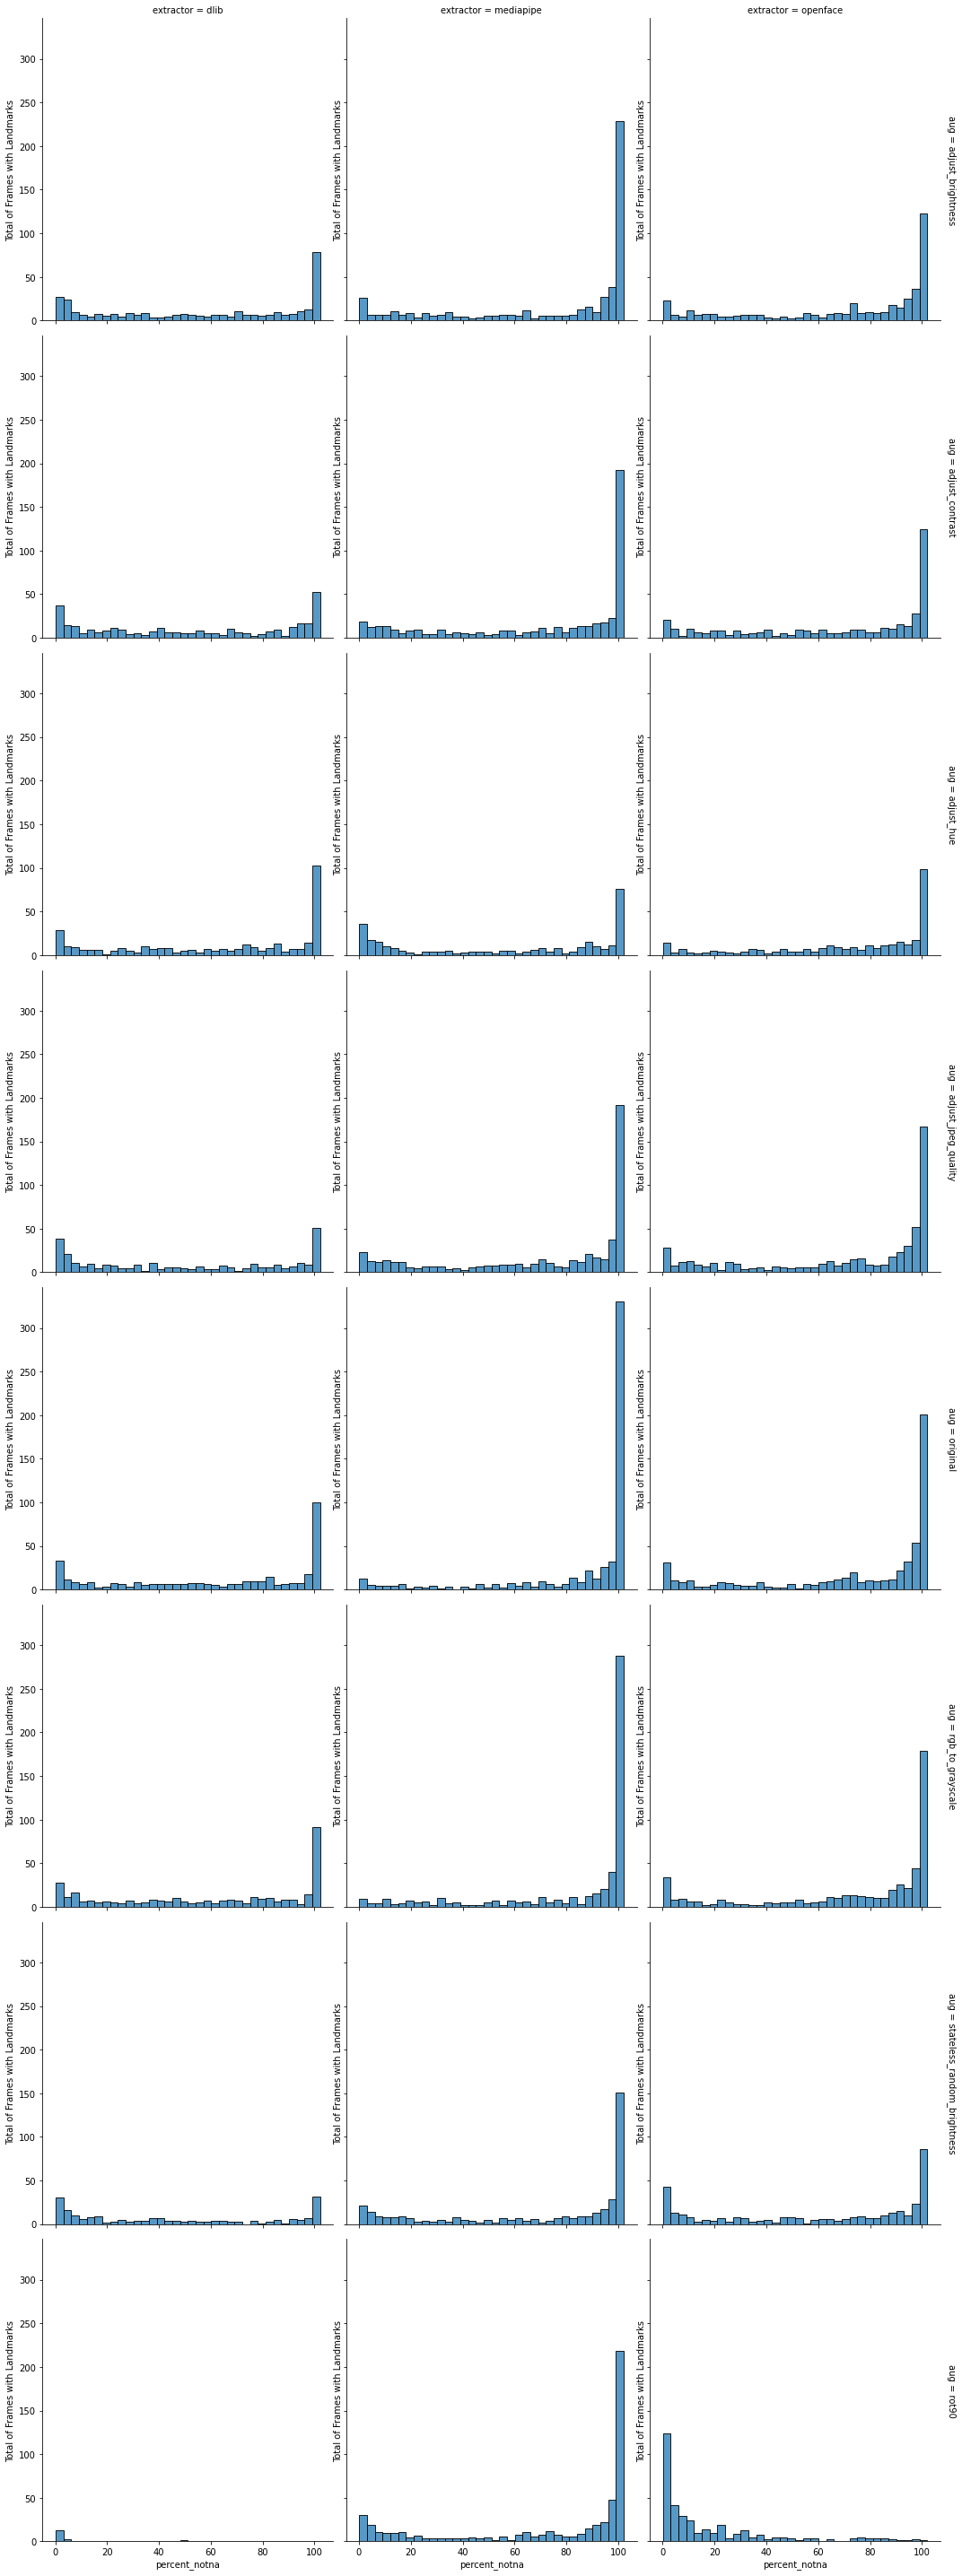

In [29]:
fig = plt.figure(figsize=(14,8))

ax =  sns.displot(
    df_diff_unit, x="percent_notna", col="extractor", row="aug",
    binwidth=3, height=5, facet_kws=dict(margin_titles=True),
)
ax.set(ylabel='Total of Frames with Landmarks')


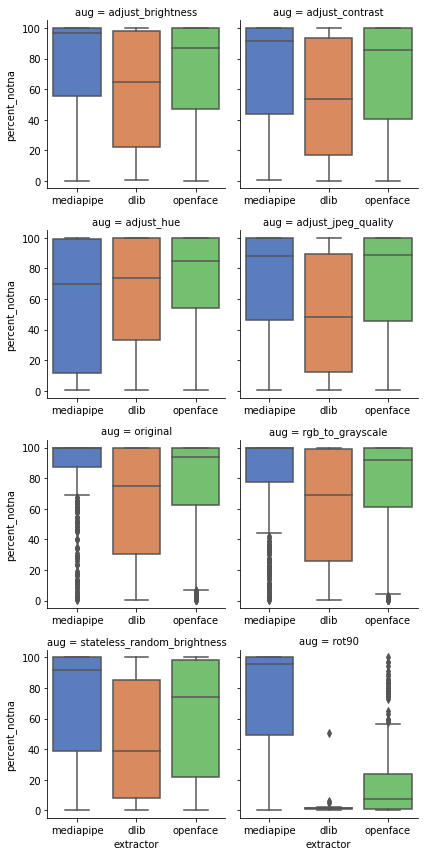

In [30]:
g = sns.FacetGrid(df_diff_unit, col='aug',col_wrap=2)
#                                               change this to 4 ^
g.map(sns.boxplot,'extractor','percent_notna',palette='muted', order=['mediapipe', 'dlib', 'openface'])
for ax in g.axes.flatten(): 
    ax.tick_params(labelbottom=True)
plt.tight_layout()
plt.show()

In [31]:
#Ao analisar a figura acima, temos que para o dataset original quando submetido ao extrator Dlib, há uma concentração de outliers considerável abaixo 70%, ou seja, de vídeos em que a porcentagem da quantidade de seus frames com landmarks detectados foi menor que 70%.

#Embora o Mediapipe tenha uma quantidade de frames detectados muito maior que o Dlib. Ao avaliar por vídeo (a unidade) e realizar um processamento de forma que para cada linha (vídeo) para encontrar a porcentagem de frames detectados nesse mesmo vídeo. Podemos ver que no Dlib, há um número considerável de outliers abaixo de 70%, isto é, há um número considerável de vídeos específicos em que o total de seus frames com landmarks detectados são abaixo de 70%.

#Resumindo, mas não concluindo. Talvez se não existissem "alguns vídeos específicos" o Dlib pode melhorar bastante a detecção de landmarks. Hipótese: Talvez "esses vídeos específicos" que tem 70% do seu corpo sem landmarks detectados, seja pelo fato de terem alguma característica em comum que deixa o Dlib sensível (como a distância da câmera ou tamanho do crop da face).

#Então vamos analisar alguns desses outliers?

#Validado (motivos):

#Ordem
#<=0.70 [0:100]
#whis=np.inf,


#16% dos dados podem ser considerados outliers...
#Qual o valor default para delimitar o que é um outlier ou não

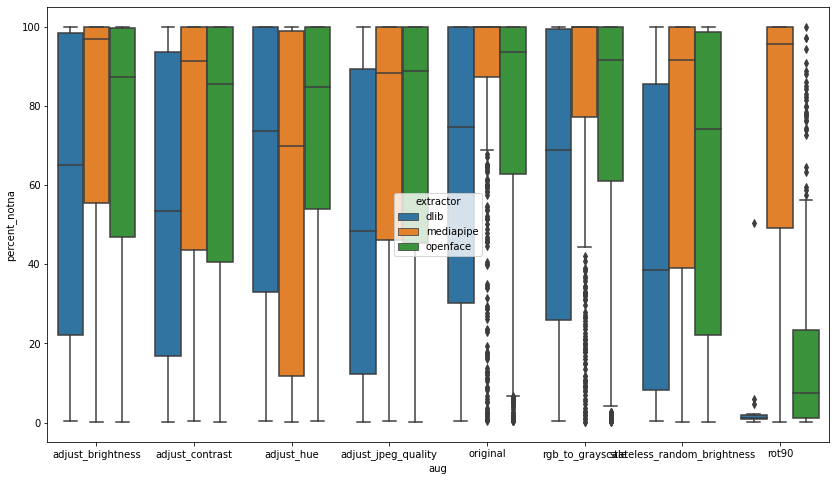

In [32]:
fig = plt.figure(figsize=(14,8))

ax = sns.boxplot(x="aug", y="percent_notna", data=df_diff_unit, hue="extractor")
#ax = sns.stripplot(x="aug", y="percent_notna", data=df_diff_unit, color=".3", hue="extractor")

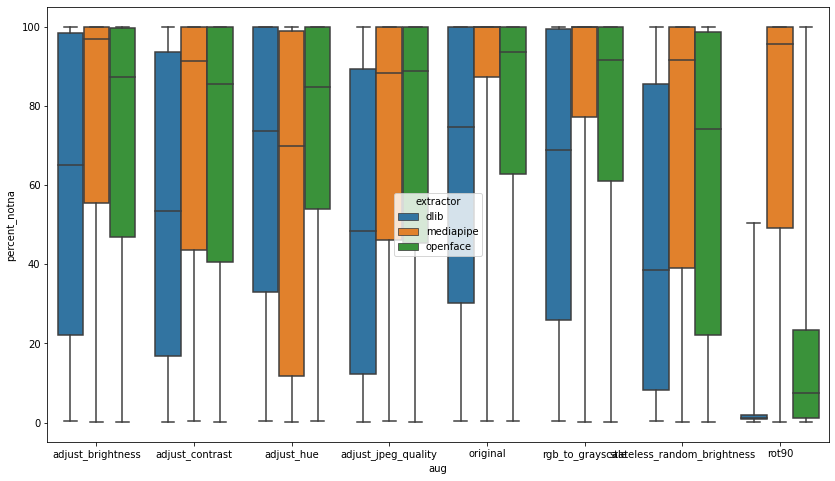

In [33]:
fig = plt.figure(figsize=(14,8))

ax = sns.boxplot(x="aug", y="percent_notna", data=df_diff_unit, whis=np.inf, hue="extractor")
#ax = sns.stripplot(x="aug", y="percent_notna", data=df_diff_unit, color=".3", hue="extractor")

In [34]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 #(df_diff_unit.extractor == 'mediapipe') & 
                 (df_diff_unit.percent_notna <= 0.70)].shape

(17, 9)

In [35]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe')].percent_notna.median()

100.0

In [36]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'dlib')].percent_notna.median()

74.63267214319109

In [37]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe')].percent_notna.quantile(.05)

13.10344827586207

In [38]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'dlib')].percent_notna.quantile(.05)

1.6484993280573392

In [39]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & (df_diff_unit.extractor == 'mediapipe') & (df_diff_unit.percent_notna < 70)]

index                video_name  extractor       aug           class  \
203     328  v_ApplyEyeMakeup_g02_c04  mediapipe  original  ApplyEyeMakeup   
386     657  v_ApplyEyeMakeup_g04_c03  mediapipe  original  ApplyEyeMakeup   
2467   4217  v_ApplyEyeMakeup_g22_c01  mediapipe  original  ApplyEyeMakeup   
2477   4251  v_ApplyEyeMakeup_g22_c02  mediapipe  original  ApplyEyeMakeup   
2515   4337  v_ApplyEyeMakeup_g22_c04  mediapipe  original  ApplyEyeMakeup   
...     ...                       ...        ...       ...             ...   
9363  20275    v_ShavingBeard_g22_c07  mediapipe  original    ShavingBeard   
9637  20824    v_ShavingBeard_g25_c01  mediapipe  original    ShavingBeard   
9653  20864    v_ShavingBeard_g25_c02  mediapipe  original    ShavingBeard   
9666  20901    v_ShavingBeard_g25_c03  mediapipe  original    ShavingBeard   
9673  20980    v_ShavingBeard_g25_c06  mediapipe  original    ShavingBeard   

      na  counts_notna  total_frames  percent_notna  
203    0            15           170       8.823529  
386    0             1           114       0.877193  
2467   0            46           170      27.058824  
2477   0           138           257      53.696498  
2515   0           121           208      58.173077  
...   ..           ...           ...            ...  
9363   0           118           202      58.415842  
9637   0            22           210      10.476190  
9653   0           116           226      51.327434  
9666   0             5           230       2.173913  
9673   0             6           235       2.553191  

[94 rows x 9 columns]

In [40]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & (df_diff_unit.extractor == 'mediapipe')].shape

(561, 9)

In [41]:
ff = df_diff_unit.loc[(df_diff_unit.aug == 'original')]

ff

index                video_name  extractor       aug           class  \
4         8  v_ApplyEyeMakeup_g01_c01       dlib  original  ApplyEyeMakeup   
11       23  v_ApplyEyeMakeup_g01_c01  mediapipe  original  ApplyEyeMakeup   
19       39  v_ApplyEyeMakeup_g01_c01   openface  original  ApplyEyeMakeup   
27       55  v_ApplyEyeMakeup_g01_c02       dlib  original  ApplyEyeMakeup   
34       68  v_ApplyEyeMakeup_g01_c02  mediapipe  original  ApplyEyeMakeup   
...     ...                       ...        ...       ...             ...   
9646  20849    v_ShavingBeard_g25_c02       dlib  original    ShavingBeard   
9653  20864    v_ShavingBeard_g25_c02  mediapipe  original    ShavingBeard   
9661  20880    v_ShavingBeard_g25_c02   openface  original    ShavingBeard   
9666  20901    v_ShavingBeard_g25_c03  mediapipe  original    ShavingBeard   
9673  20980    v_ShavingBeard_g25_c06  mediapipe  original    ShavingBeard   

      na  counts_notna  total_frames  percent_notna  
4      0            64           164      39.024390  
11     0           151           164      92.073171  
19     0           160           164      97.560976  
27     0            92           123      74.796748  
34     0           123           123     100.000000  
...   ..           ...           ...            ...  
9646   0            17           226       7.522124  
9653   0           116           226      51.327434  
9661   0            34           226      15.044248  
9666   0             5           230       2.173913  
9673   0             6           235       2.553191  

[1473 rows x 9 columns]

In [42]:
path_visual = './../../data/raw/UCF-101-Analysis/ApplyEyeMakeup/'
l_videos = sorted(os.listdir(path_visual))

video1 = media.read_video(path_visual+str(l_videos[0]))
video2 = media.read_video(path_visual+str(l_videos[1]))
video3 = media.read_video(path_visual+str(l_videos[2]))
video4 = media.read_video(path_visual+str(l_videos[3]))
video5 = media.read_video(path_visual+str(l_videos[4]))
video6 = media.read_video(path_visual+str(l_videos[5]))
video7 = media.read_video(path_visual+str(l_videos[6]))
video8 = media.read_video(path_visual+str(l_videos[7]))
video9 = media.read_video(path_visual+str(l_videos[8]))
video10 = media.read_video(path_visual+str(l_videos[9]))

# Show multiple videos side-by-side.
s = 90
vis_videos = {
    'v_ApplyEyeMakeup_g01_c02-DLIB': video1,
    'v_ApplyEyeMakeup_g01_c02-MEDIAPIPE': video2,
    'v_PlayingFlute_g02_c06-DLIB': video3,
    'v_PlayingFlute_g02_c06-MEDIAPIPE': video4,
    'v_PlayingFlute_g03_c07-DLIB': video5,
    'v_PlayingFlute_g03_c07-MEDIAPIPE': video6,
    'v_ShavingBeard_g03_c03-DLIB': video7,
    'v_ShavingBeard_g03_c03-MEDIAPIPE': video8,
    'v_ShavingBeard_g04_c02-DLIB': video9,
    'v_ShavingBeard_g04_c02-MEDIAPIPE': video10,
    
}
media.show_videos(vis_videos, fps=25, columns=2)

# Por classe

<Figure size 1008x576 with 0 Axes>

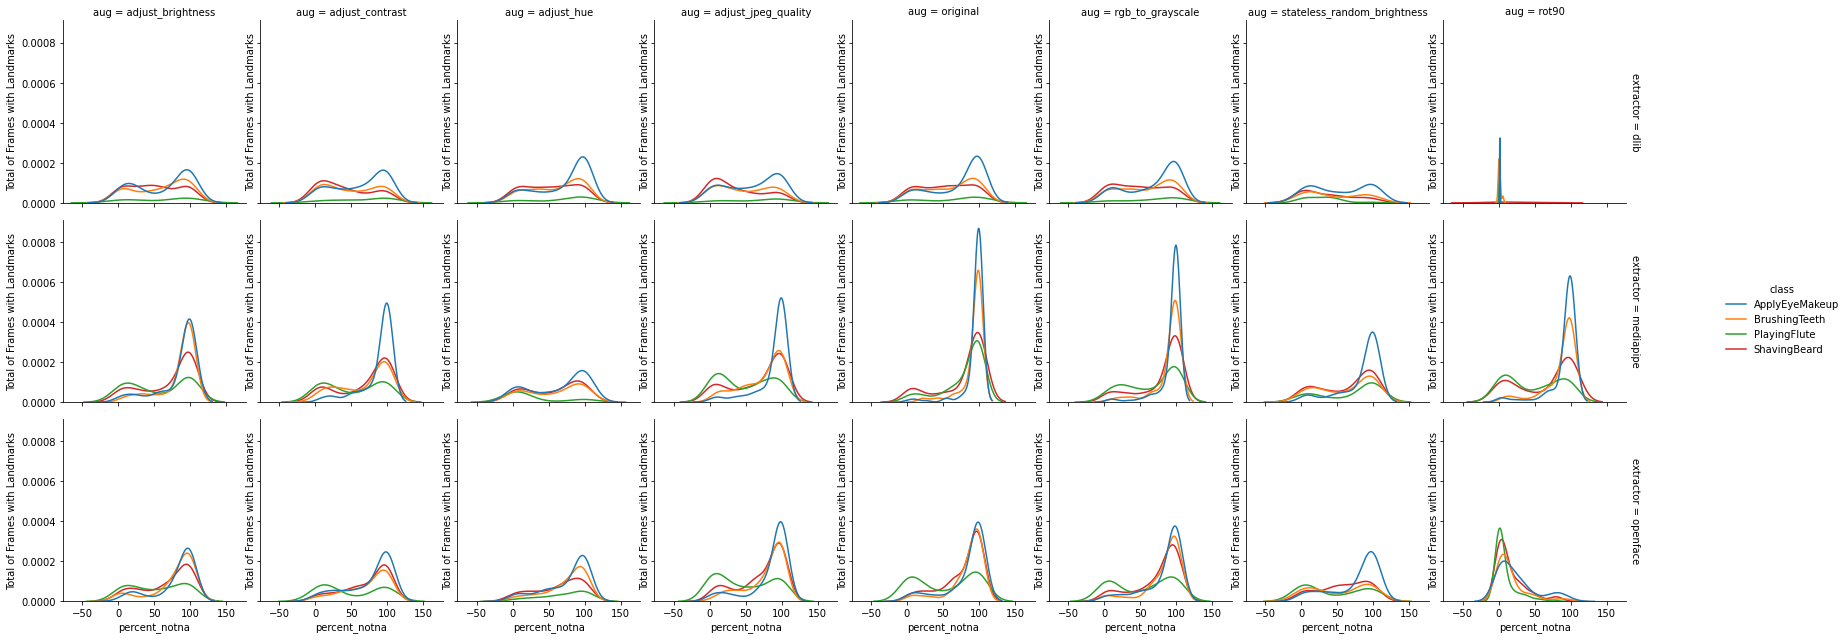

In [43]:
fig = plt.figure(figsize=(14,8))

ax =  sns.displot(
    df_diff_unit, x="percent_notna", row="extractor", col="aug", hue='class',
     height=3, facet_kws=dict(margin_titles=True), kind="kde", 
)
ax.set(ylabel='Total of Frames with Landmarks')

De maneira geral, analisando as figuras acima, podemos perceber que na maior parte dos casos, ambos os extratores, tiveram uma taxa maior de detecção em frames da classe ApplyEyeMakeup, enquanto que para as classes PlayingFlute e ShavingBeard, ambos os extratores apresentaram as menores taxas de detecção.

In [44]:
def get_total_frames_class(ext, aug, total_frames):
    return total_frames.loc[(total_frames.extractor == ext) & 
                            (total_frames.aug == aug)].reset_index().at[0,'total_frames'] #index, col

In [45]:
total_frames = df_combined.groupby(['extractor', 'aug', 'class']).size().reset_index(name='total_frames')

df_diff_class = df_combined.groupby(['extractor', 'aug', 'class', 'na']).size().reset_index(name='counts_notna')
df_diff_class = df_diff_class.loc[df_diff_class.na == 0].reset_index()
df_diff_class['total_frames'] = df_diff_class.apply(lambda x: get_total_frames_class( x['extractor'], x['aug'], total_frames), axis=1)
df_diff_class['percent_notna'] = df_diff_class['counts_notna']/df_diff_class['total_frames']*100
df_diff_class#.loc[df_diff_unit['class'] == 'v_ApplyEyeMakeup_g01_c01.avi']

index extractor                          aug           class  na  \
0       0      dlib            adjust_brightness  ApplyEyeMakeup   0   
1       2      dlib            adjust_brightness   BrushingTeeth   0   
2       4      dlib            adjust_brightness    PlayingFlute   0   
3       6      dlib            adjust_brightness    ShavingBeard   0   
4       8      dlib              adjust_contrast  ApplyEyeMakeup   0   
..    ...       ...                          ...             ...  ..   
91    182  openface                        rot90    ShavingBeard   0   
92    184  openface  stateless_random_brightness  ApplyEyeMakeup   0   
93    186  openface  stateless_random_brightness   BrushingTeeth   0   
94    188  openface  stateless_random_brightness    PlayingFlute   0   
95    190  openface  stateless_random_brightness    ShavingBeard   0   

    counts_notna  total_frames  percent_notna  
0          12326         24358      50.603498  
1          13733         24358      56.379834  
2           4423         24358      18.158305  
3          10179         24358      41.789145  
4          12650         24358      51.933656  
..           ...           ...            ...  
91          3523         24358      14.463421  
92         15595         24358      64.024140  
93         10159         24358      41.707037  
94         10155         24358      41.690615  
95         11084         24358      45.504557  

[96 rows x 8 columns]

<Figure size 1008x576 with 0 Axes>

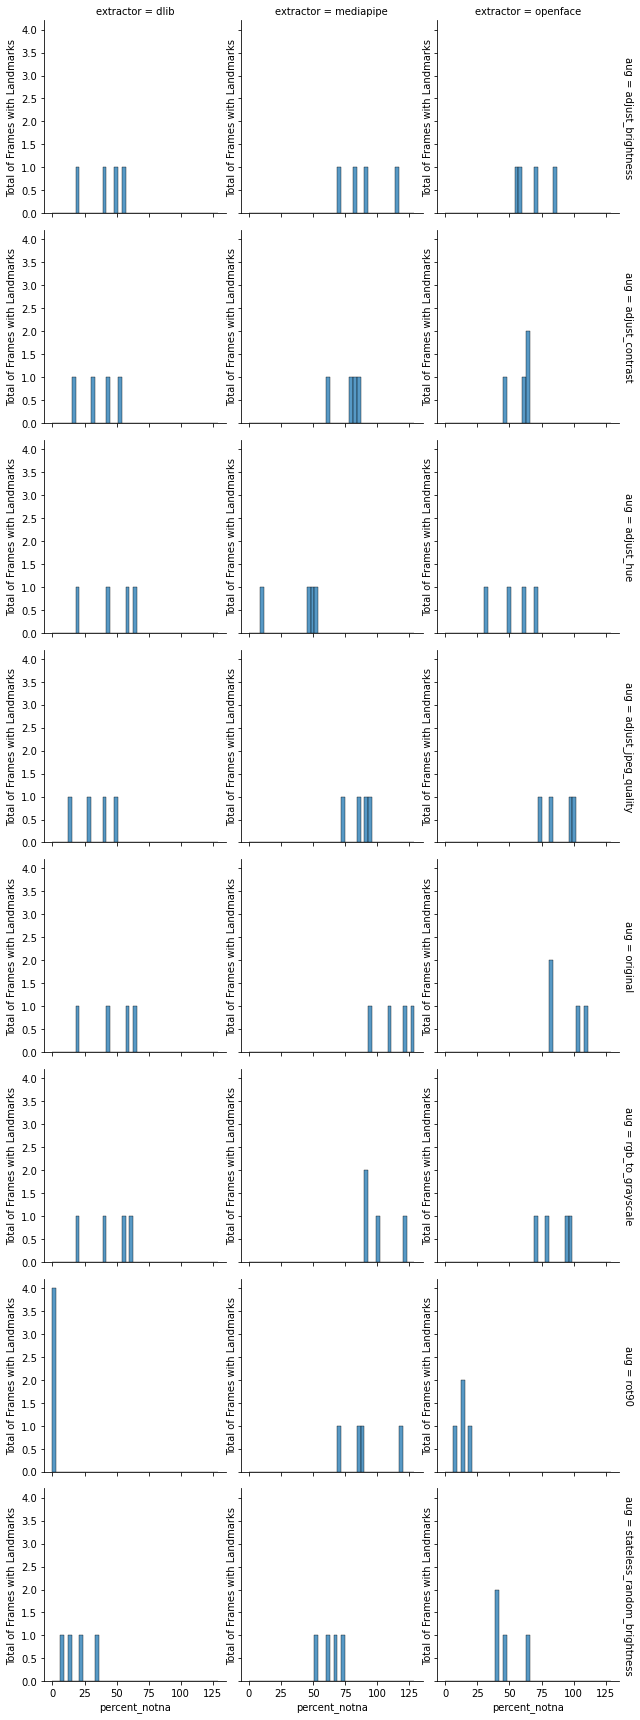

In [46]:
fig = plt.figure(figsize=(14,8))

ax =  sns.displot(
    df_diff_class, x="percent_notna", col="extractor", row="aug",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)
ax.set(ylabel='Total of Frames with Landmarks')


# Outilers

In [93]:
ff

index                video_name  extractor       aug           class  \
4         8  v_ApplyEyeMakeup_g01_c01       dlib  original  ApplyEyeMakeup   
11       23  v_ApplyEyeMakeup_g01_c01  mediapipe  original  ApplyEyeMakeup   
19       39  v_ApplyEyeMakeup_g01_c01   openface  original  ApplyEyeMakeup   
27       55  v_ApplyEyeMakeup_g01_c02       dlib  original  ApplyEyeMakeup   
34       68  v_ApplyEyeMakeup_g01_c02  mediapipe  original  ApplyEyeMakeup   
...     ...                       ...        ...       ...             ...   
9646  20849    v_ShavingBeard_g25_c02       dlib  original    ShavingBeard   
9653  20864    v_ShavingBeard_g25_c02  mediapipe  original    ShavingBeard   
9661  20880    v_ShavingBeard_g25_c02   openface  original    ShavingBeard   
9666  20901    v_ShavingBeard_g25_c03  mediapipe  original    ShavingBeard   
9673  20980    v_ShavingBeard_g25_c06  mediapipe  original    ShavingBeard   

      na  counts_notna  total_frames  percent_notna  
4      0            64           164      39.024390  
11     0           151           164      92.073171  
19     0           160           164      97.560976  
27     0            92           123      74.796748  
34     0           123           123     100.000000  
...   ..           ...           ...            ...  
9646   0            17           226       7.522124  
9653   0           116           226      51.327434  
9661   0            34           226      15.044248  
9666   0             5           230       2.173913  
9673   0             6           235       2.553191  

[1473 rows x 9 columns]

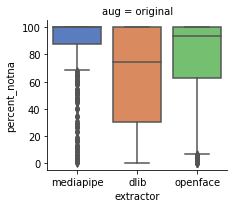

In [47]:
g = sns.FacetGrid(ff, col='aug',col_wrap=2)
#                                               change this to 4 ^
g.map(sns.boxplot,'extractor','percent_notna',palette='muted', order=['mediapipe', 'dlib', 'openface'])
for ax in g.axes.flatten(): 
    ax.tick_params(labelbottom=True)
plt.tight_layout()
plt.show()

In [48]:
df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe') &
                (df_diff_unit.extractor == 'openface')].percent_notna.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: percent_notna, dtype: float64

In [49]:
#https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
from scipy import stats
df = df_diff_unit.loc[(df_diff_unit.aug == 'original') & 
                 (df_diff_unit.extractor == 'mediapipe')]
df[(np.abs(stats.zscore(df['percent_notna'])) > 3)].sort_values(by = 'counts_notna')

index                video_name  extractor       aug           class  \
386     657  v_ApplyEyeMakeup_g04_c03  mediapipe  original  ApplyEyeMakeup   
5891  11926    v_PlayingFlute_g09_c02  mediapipe  original    PlayingFlute   
6652  14106    v_PlayingFlute_g20_c03  mediapipe  original    PlayingFlute   
8626  18534    v_ShavingBeard_g16_c03  mediapipe  original    ShavingBeard   
8894  19178    v_ShavingBeard_g18_c07  mediapipe  original    ShavingBeard   
5866  11805    v_PlayingFlute_g08_c05  mediapipe  original    PlayingFlute   
8643  18599    v_ShavingBeard_g16_c05  mediapipe  original    ShavingBeard   
5440  10334    v_PlayingFlute_g02_c02  mediapipe  original    PlayingFlute   
5671  11226    v_PlayingFlute_g06_c02  mediapipe  original    PlayingFlute   
9666  20901    v_ShavingBeard_g25_c03  mediapipe  original    ShavingBeard   
8636  18568    v_ShavingBeard_g16_c04  mediapipe  original    ShavingBeard   
9673  20980    v_ShavingBeard_g25_c06  mediapipe  original    ShavingBeard   
8393  18055    v_ShavingBeard_g14_c03  mediapipe  original    ShavingBeard   
8402  18088    v_ShavingBeard_g14_c04  mediapipe  original    ShavingBeard   
7428  15846    v_ShavingBeard_g04_c04  mediapipe  original    ShavingBeard   
5673  11252    v_PlayingFlute_g06_c03  mediapipe  original    PlayingFlute   
8306  17781    v_ShavingBeard_g13_c01  mediapipe  original    ShavingBeard   
8385  18023    v_ShavingBeard_g14_c02  mediapipe  original    ShavingBeard   
9109  19691    v_ShavingBeard_g20_c06  mediapipe  original    ShavingBeard   

      na  counts_notna  total_frames  percent_notna  
386    0             1           114       0.877193  
5891   0             1           278       0.359712  
6652   0             1           100       1.000000  
8626   0             2           227       0.881057  
8894   0             3           311       0.964630  
5866   0             3           390       0.769231  
8643   0             3           240       1.250000  
5440   0             4           246       1.626016  
5671   0             5           218       2.293578  
9666   0             5           230       2.173913  
8636   0             6           252       2.380952  
9673   0             6           235       2.553191  
8393   0             7           263       2.661597  
8402   0             7           222       3.153153  
7428   0             8           211       3.791469  
5673   0             8           152       5.263158  
8306   0            10           170       5.882353  
8385   0            11           207       5.314010  
9109   0            17           257       6.614786

In [50]:
df['path'] = df[['class', 'video_name']].agg('/'.join, axis=1)
l_videos = df.sample(n=10, random_state=1).reset_index()['path']
df.sample(n=10, random_state=1).reset_index()[['video_name', 'percent_notna']].sort_values(by='percent_notna')

/home/jms2/anaconda3/envs/2way/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


video_name  percent_notna
1    v_ShavingBeard_g06_c07      61.354582
3    v_ShavingBeard_g20_c02      73.170732
9    v_ShavingBeard_g21_c04      92.528736
8  v_ApplyEyeMakeup_g15_c03      97.844828
0  v_ApplyEyeMakeup_g08_c04     100.000000
2   v_BrushingTeeth_g17_c01     100.000000
4    v_ShavingBeard_g05_c02     100.000000
5    v_PlayingFlute_g16_c01     100.000000
6   v_BrushingTeeth_g19_c03     100.000000
7   v_BrushingTeeth_g06_c03     100.000000

In [51]:
l_videos

0    ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04
1        ShavingBeard/v_ShavingBeard_g06_c07
2      BrushingTeeth/v_BrushingTeeth_g17_c01
3        ShavingBeard/v_ShavingBeard_g20_c02
4        ShavingBeard/v_ShavingBeard_g05_c02
5        PlayingFlute/v_PlayingFlute_g16_c01
6      BrushingTeeth/v_BrushingTeeth_g19_c03
7      BrushingTeeth/v_BrushingTeeth_g06_c03
8    ApplyEyeMakeup/v_ApplyEyeMakeup_g15_c03
9        ShavingBeard/v_ShavingBeard_g21_c04
Name: path, dtype: object

In [52]:
path_visual = './../../data/raw/UCF-101-Analysis/'
#l_videos = sorted(os.listdir(path_visual+classe))

video1 = media.read_video(path_visual+str(l_videos[0]))
video2 = media.read_video(path_visual+str(l_videos[1]))
video3 = media.read_video(path_visual+str(l_videos[2]))
video4 = media.read_video(path_visual+str(l_videos[3]))
video5 = media.read_video(path_visual+str(l_videos[4]))
video6 = media.read_video(path_visual+str(l_videos[5]))
video7 = media.read_video(path_visual+str(l_videos[6]))
video8 = media.read_video(path_visual+str(l_videos[7]))
video9 = media.read_video(path_visual+str(l_videos[8]))
video10 = media.read_video(path_visual+str(l_videos[9]))

# Show multiple videos side-by-side.
s = 90
vis_videos = {
    l_videos[0]: video1,
    l_videos[1]: video2,
    l_videos[2]: video3,
    l_videos[3]: video4,
    l_videos[4]: video5,
    l_videos[5]: video6,
    l_videos[6]: video7,
    l_videos[7]: video8,
    l_videos[8]: video9,
    l_videos[9]: video10,
    
}
media.show_videos(vis_videos, fps=25, columns=2)

RuntimeError: Video file './../../data/raw/UCF-101-Analysis/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04' is not found.

In [ ]:
- Escala de Cinza
- Super Resolution
- Motion Blur

In [ ]:
Histograma, por categoria/similaridade.

Teste de Hipótese com os valores de diferença de cada amostra para o geral